In [1]:
"""Metric Learning."""

import datetime
from ast import literal_eval
from types import MethodType

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import clear_output
from torch import nn, optim
from torch.nn import TripletMarginLoss
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from playlist_selection.logging_config import get_logger

LOGGER = get_logger("root")
RANDOM_STATE = 42

In [2]:
session = boto3.Session(profile_name="project")
client = session.client("s3")

bucket = "hse-project-playlist-selection"
dataset_key = "dataset/filtered_data_30_11_23.csv"

body = client.get_object(Bucket=bucket, Key=dataset_key)["Body"]
df = pd.read_csv(body, index_col=0)

for column in "genres", "artist_name":
    df[column] = df[column].apply(literal_eval)

df.dropna(inplace=True)
df["album_release_date"] = pd.to_datetime(df["album_release_date"], format="mixed")
df = df.reset_index(drop=True)

df.head(1).T

2024-03-03 20:36:01,220 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-03-03 20:36:02,154 - botocore.configprovider - INFO - Found endpoint for s3 via: config_global.


,0
key,61_HighwayCorey_Harris
genre,acoustic
audio_path,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3
album_name,Between Midnight And Day
album_id,6fuRNpnOE7QgyT1IcdvpED
album_release_date,1995-10-31 00:00:00
artist_name,[Corey Harris]
artist_id,['1TQtbRQbaXw5CeN3mC0DJH']
track_id,3zGcBpopIzVBqqHRoRTCR2
track_name,61 Highway


# *Фичи

Для эксперимента возьмём просто числовые фичи из меты. Позже вместо них будем использовать эмбединги.

In [3]:
DROP_COLUMNS = [
    "diff_sec",
    "file_size_mb",
    "duration_ms",
]

def get_numeric_features(dataset: pd.DataFrame) -> list[str]:
    """Extract numeric features list from dataset."""
    idx = (dataset.select_dtypes(np.number).sample(50, random_state=RANDOM_STATE).nunique() == 50).index
    numeric_columns = dataset.loc[:, idx].select_dtypes(np.number).columns
    numeric_columns = numeric_columns.drop(labels=DROP_COLUMNS).tolist()
    return numeric_columns

numeric_features = get_numeric_features(df)
for numeric_feature in numeric_features:
    df[numeric_feature] = df[numeric_feature].astype(float)
df.loc[:, numeric_features].head(1)


,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,...,sections_mean_time_signature,segments_number,segments_mean_duration,segments_mean_pitch,segments_max_pitch,segments_min_pitch,segments_mean_timbre,segments_max_timbre,segments_min_timbre,real_duration_ms
0,5.0,0.637,0.0229,-22.846,1.0,0.044,0.907,0.000145,0.226,80.923,...,4.0,780.0,0.318523,0.255563,1.0,0.0398,-5.691454,66.999615,-89.520079,288578.0


# ArcFace

## Dataset

In [4]:
import itertools  # noqa E420

from sklearn.preprocessing import LabelEncoder  # noqa E420


df_arcface = df.copy()

df_arcface["decade"] = (df_arcface["album_release_date"].dt.year // 10) * 10
df_arcface["target"] = df_arcface["genre"] + df_arcface["decade"].astype(str)

encoder = LabelEncoder()
df_arcface["target"] = encoder.fit_transform(df_arcface["target"])

df_arcface.head()

,key,genre,audio_path,album_name,album_id,album_release_date,artist_name,artist_id,track_id,track_name,...,segments_min_timbre,real_key,real_duration_ms,file_size_mb,diff_sec,flag_duration_diff_lt_5,flag_size_not_null_and_lt_10,flag_is_valid,decade,target
0,61_HighwayCorey_Harris,acoustic,tracks/acoustic/61_HighwayCorey_Harris/audio.mp3,Between Midnight And Day,6fuRNpnOE7QgyT1IcdvpED,1995-10-31,[Corey Harris],['1TQtbRQbaXw5CeN3mC0DJH'],3zGcBpopIzVBqqHRoRTCR2,61 Highway,...,-89.520079,61_HighwayCorey_Harris,288578.0,1.680138,-0.058,True,True,True,1990,4
1,A_Rat_In_My_DreamBlackbird_Raum,acoustic,tracks/acoustic/A_Rat_In_My_DreamBlackbird_Rau...,Swidden,2FQOhgfjT2SY5ftlJPo2J0,2010-10-05,[Blackbird Raum],['2OX8UjaYkhqkZN9n7kbQLx'],6f3gH7xUWu2maSO8pMWza0,A Rat In My Dream,...,-47.035636,A_Rat_In_My_DreamBlackbird_Raum,44722.0,0.261071,23.571,False,True,False,2010,6
2,A_Whole_New_WorldDisney_Peaceful_Guitar,acoustic,tracks/acoustic/A_Whole_New_WorldDisney_Peacef...,Disney Guitar: Breathe,1BkRLMg1PwegXipKVRXeiI,2020-08-07,"[Disney Peaceful Guitar, Disney]","['3oqzxUlHhjJ7auI4dVujKX', '3xvaSlT4xsyk6lY1ES...",4PMQ9IidXtvDdhmlH4IBPD,A Whole New World,...,-87.081986,A_Whole_New_WorldDisney_Peaceful_Guitar,173035.0,1.007382,-5.326,True,True,True,2020,7
3,Ab's_SongIron_&_Wine,acoustic,tracks/acoustic/Ab's_SongIron_&_Wine/audio.mp3,Sing Into My Mouth,0jMBAo2pk2cEE0aJ3WseMl,2015-07-17,"[Iron & Wine, Ben Bridwell]","['4M5nCE77Qaxayuhp3fVn4V', '6Vfn70eqp3AgtiZZtQ...",0lovF4eevVqfpVRNYzfmmV,Ab's Song,...,-54.978156,Ab's_SongIron_&_Wine,79459.0,0.464166,-0.093,True,True,True,2010,6
4,Across_the_BorderlineRy_Cooder,acoustic,tracks/acoustic/Across_the_BorderlineRy_Cooder...,Music by Ry Cooder,0gLaTb6BP8pySUWwkiZjdD,1995-01-01,[Ry Cooder],['1CPwHx5lgVxv0rfcp7UXLx'],64CFnGFSt0rzznXD2XUGUQ,Across the Borderline,...,-64.809298,Across_the_BorderlineRy_Cooder,375188.0,2.159058,-190.148,True,True,True,1990,4


In [5]:
class ArcFaceDataset(Dataset):
    """Dataset for audio features."""
    
    def __init__(self, df: pd.DataFrame, numeric_features: list[str], target_col: str = "target"):
        """DF - dataframe with audio metadata."""
        self.df = df
        self.numeric_features = numeric_features
        self.target_col = target_col
        
    def __len__(self) -> int:
        """Size of dataset."""
        return self.df.shape[0]
        
    def __getitem__(self, idx: int) -> torch.tensor:
        """Index - id (?) of anchor track."""
        sample = self.df.iloc[idx]
        return {
            "features": torch.from_numpy(sample[self.numeric_features].to_numpy(dtype="float32")),
            "target": torch.tensor([sample[self.target_col]]),
        }

## Model

In [59]:
import math  # noqa E402

import torch.nn.functional as F  # noqa E402


class Backbone(nn.Module):
    """Simple MLP implementation."""
    def __init__(self, input_size=32, embedding_size=256):
        """Initialize object."""
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, embedding_size),
            # nn.BatchNorm1d(embedding_size),
            # nn.ReLU(),
        )
        
    def forward(self, x):
        """Forward pass."""
        x = self.fc(x)
        return x


class ArcMarginProduct(nn.Module):
    """Implement of large margin arc distance.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin

        cos(theta + m)
    """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, device: str = "cpu"):
        """Initialize ArcFace Module."""
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.device = device


    def forward(self, input, label):
        """Forward pass."""
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosin = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosin, 2)).clamp(0, 1))

        phi = cosin * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosin > 0, phi, cosin)
        else:
            phi = torch.where(cosin > self.th, phi, cosin - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosin.size(), device=self.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosin)  # you can use torch.where if your torch version is 0.4
        output *= self.s
        # print(output)

        return output
    

class ArcFaceModel(nn.Module):
    """Simple MLP implementation."""
    def __init__(
            self,
            output_size,
            input_size=32,
            embedding_size=256,
            s=30.0,
            m=0.50,
            easy_margin=False,
            device: str = "cpu",
        ):
        """Initialize object."""
        super().__init__()
        self.backbone = Backbone(input_size=input_size, embedding_size=embedding_size)
        self.arcface_module = ArcMarginProduct(
            in_features=embedding_size,
            out_features=output_size,
            s=s,
            m=m,
            easy_margin=easy_margin,
            device=device,
        )
        
    def forward(self, features, labels):
        """Forward pass."""
        output = self.backbone(features)
        output = self.arcface_module(output, labels)
        return output

In [107]:
from sklearn.model_selection import train_test_split  # noqa E402
from pytorch_metric_learning.losses import ArcFaceLoss  # noqa E402

EPOCHS = 1
BATCH_SIZE = 64
EMBEDDING_SIZE = 256

LR = 1e-3
SCALE = 30
MARGIN = 0.5
EASY_MARGIN = True
DEVICE = "cpu"

train_df, val_df = train_test_split(df_arcface, test_size=0.4, stratify=df["genre"], random_state=RANDOM_STATE)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = ArcFaceDataset(df=train_df, numeric_features=numeric_features)
val_dataset = ArcFaceDataset(df=val_df, numeric_features=numeric_features)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

output_len = df_arcface["target"].nunique()

model = ArcFaceModel(
    output_len,
    input_size=len(numeric_features),
    embedding_size=EMBEDDING_SIZE,
    s=SCALE,
    m=MARGIN,
    easy_margin=EASY_MARGIN,
    device=DEVICE,
)

# model = Backbone(embedding_size=EMBEDDING_SIZE)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
# criterion = ArcFaceLoss(embedding_size=EMBEDDING_SIZE, num_classes=output_len, scale=SCALE, margin=MARGIN)

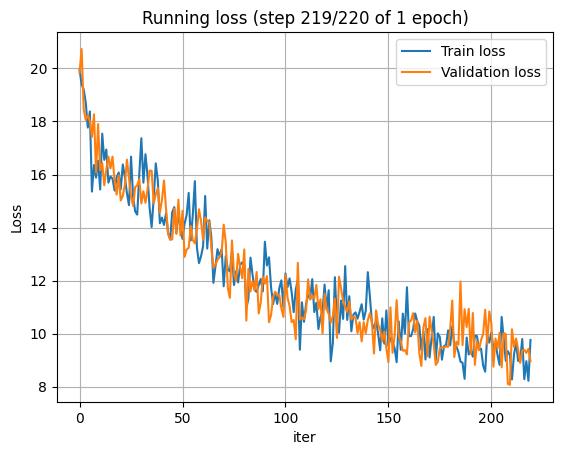

2024-03-04 00:37:47,614 - root - INFO - Epoch: 1/1 - Loss: 12.00750737623735


In [108]:
def run_training(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        n_epochs: int = 1,
        plot: bool = True,
        early_stopping_rounds: int | None = 50,
    ):
    """Training loop function."""
    model.train()

    min_loss = 1e5
    early_stopping_cnt = 0
    best_model_state_dict = {}
    LOGGER.info("Starting training process..")
    for epoch in tqdm(range(n_epochs), desc="Epochs"):
        running_loss = []
        val_running_loss = []
        for step, objects in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            
            optimizer.zero_grad()
            logits = model(objects["features"], objects["target"])
            # logits = model(objects["features"])
            loss = criterion(logits, objects["target"].squeeze().long())

            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy().tolist())
            
            with torch.no_grad():
                model.eval()
                val_objects = next(iter(val_loader))

                val_logits = model(val_objects["features"], val_objects["target"])
                # val_logits = model(val_objects["features"])

                val_loss = criterion(val_logits, val_objects["target"].squeeze().long())
                val_running_loss.append(val_loss.cpu().detach().numpy().tolist())
                model.train()

            LOGGER.info(
                "Epoch: %s/%s; STEP: %s - Train loss: %s; Validation loss: %s", epoch+1, n_epochs, step, loss, val_loss
            )

            if val_loss <= min_loss:
                early_stopping_cnt = 0
                min_loss = val_loss
                best_model_state_dict = model.state_dict()
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_rounds:
                model = model.load_state_dict(best_model_state_dict)
                return            
            
            if plot:
                clear_output(wait=True)
                fig, ax = plt.subplots(1, 1)
                sns.lineplot(x=range(len(running_loss)), y=running_loss, ax=ax, label="Train loss")
                sns.lineplot(x=range(len(val_running_loss)), y=val_running_loss, ax=ax, label="Validation loss")
                ax.grid(True)
                ax.legend()
                ax.set_xlabel("iter")
                ax.set_ylabel("Loss")
                ax.set_title(f"Running loss (step {step}/{len(train_loader)} of {epoch + 1} epoch)")
                plt.show()

        LOGGER.info("Epoch: %s/%s - Loss: %s", epoch+1, n_epochs, np.mean(running_loss))
    model = model.load_state_dict(best_model_state_dict)


run_training(model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, criterion=criterion, early_stopping_rounds=100)

In [109]:
df_final =  pd.DataFrame()
for step, objects in enumerate(tqdm(val_loader, desc="Inference", leave=False)):
    embeddings = model.backbone(objects["features"]).detach().numpy()
    # embeddings = model(objects["features"]).detach().numpy()
    df_temp = pd.DataFrame(objects["features"].numpy(), columns=numeric_features)
    df_temp["target"] = encoder.inverse_transform(objects["target"].detach().numpy())
    df_temp["embedding"] = embeddings.tolist()

    df_final = pd.concat([df_final, df_temp], ignore_index=True)

Inference:   0%|          | 0/147 [00:00<?, ?it/s]

c:\Users\sarae\AppData\Local\pypoetry\Cache\virtualenvs\project-8Trht4WR-py3.10\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sarae\AppData\Local\pypoetry\Cache\virtualenvs\project-8Trht4WR-py3.10\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sarae\AppData\Local\pypoetry\Cache\virtualenvs\project-8Trht4WR-py3.10\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sarae\AppData\Local

In [110]:
from typing import Callable  # noqa E402
from itertools import combinations  # noqa E402

from scipy.spatial.distance import cosine, euclidean  # noqa E402


def pairwise_distance(anchor: np.array, positives: np.array, negatives: np.array):
    euclidean_dist_pos = []
    cosine_dist_pos = []
    for pos in positives:
        euclidean_dist_pos.append(euclidean(anchor, pos))
        cosine_dist_pos.append(cosine(anchor, pos))

    euclidean_dist_neg = []
    cosine_dist_neg = []
    for neg in negatives:
        euclidean_dist_neg.append(euclidean(anchor, neg))
        cosine_dist_neg.append(cosine(anchor, neg))

    return {
        "euclidean_pos": np.mean(euclidean_dist_pos),
        "euclidean_neg": np.mean(euclidean_dist_neg),
        "cosine_pos": np.mean(cosine_dist_pos),
        "cosine_neg": np.mean(cosine_dist_neg),
    }


In [111]:
N_SAMPLES = 5
results = []

for genre_ in df_final.target.unique():
    df_genre = df_final[df_final.target == genre_]
    df_other_genre = df_final[df_final.target != genre_]

    if df_genre.shape[0] < 6:
        continue

    pos_samples = df_genre.sample(N_SAMPLES + 1)["embedding"]
    neg_samples = df_other_genre.sample(N_SAMPLES)["embedding"]
    dists = pairwise_distance(
        anchor=pos_samples.iloc[0],
        positives=pos_samples.iloc[1:],
        negatives=neg_samples.tolist(),
    )
    results.append(
        {
            "genre": genre_,
            **dists,
        }
    )

In [112]:
df_res = pd.DataFrame(results)
df_res

,genre,euclidean_pos,euclidean_neg,cosine_pos,cosine_neg
0,disco2020,2.874810,2.023497,0.143255,0.077322
1,french2010,4.818004,2.898237,0.532964,0.243909
2,cantopop2000,3.116624,5.071345,0.280798,0.517082
3,groove1990,3.837946,5.772148,0.184620,0.555639
4,forro2000,2.562569,9.599914,0.115354,0.210842
...,...,...,...,...,...
423,grindcore2000,3.500826,3.352312,0.256508,0.220948
424,grindcore1990,6.874457,6.737852,0.690630,0.766090
425,sleep2010,5.430159,4.277314,0.359500,0.392890
426,samba2020,2.966382,2.949543,0.237307,0.307936


In [113]:
(df_res.euclidean_neg > df_res.euclidean_pos).mean(), (df_res.cosine_neg > df_res.cosine_pos).mean() # my 128 30 0.5

(0.6004672897196262, 0.6098130841121495)

In [99]:
(df_res.euclidean_neg > df_res.euclidean_pos).mean(), (df_res.cosine_neg > df_res.cosine_pos).mean() # my 256 30 0.5

(0.6401869158878505, 0.6799065420560748)

# TODO:

* более умная валидация (+ наши метрики)
* PML
* arcface loss?
* другие подходы